In [2]:
from google.colab import files
uploaded = files.upload()

Saving Grammar_Correction_Expanded.csv to Grammar_Correction_Expanded.csv


In [3]:
!pip install rouge-score --quiet

In [4]:
# Import libraries
import os
import time
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Load dataset
DATA_PATH = '/content/Grammar_Correction_Expanded.csv'
df = pd.read_csv(DATA_PATH)

# Select relevant columns and drop missing values
df = df[['Ungrammatical Statement', 'Standard English']].dropna()
df.columns = ['input_text', 'target_text']

# Add start and end tokens to target text
df['target_text'] = df['target_text'].apply(lambda x: "<start> " + x.lower().strip() + " <end>")
df['input_text'] = df['input_text'].apply(lambda x: x.lower().strip())

# Display sample data
df.head()


,input_text,target_text
0,the most most powerful superhero is superman.,<start> the most powerful superhero is superma...
1,the hotel room is more smaller than i expected.,<start> the hotel room is smaller than i expec...
2,"23. beauty is in the eye of the beholder, but ...",<start> 23. beauty is in the eye of the behold...
3,the new intern is a quick learner and always k...,<start> the new intern is a quick learner and ...
4,"the job requires research skills, good communi...","<start> the job requires research skills, good..."


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Split data into training and testing sets
train_src, test_src, train_tgt, test_tgt = train_test_split(
    df['input_text'], df['target_text'], test_size=0.1, random_state=42
)

# Define vocabulary size
SRC_VOCAB = 10000
TGT_VOCAB = 10000

# Initialize tokenizers
src_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=SRC_VOCAB, oov_token="<unk>")
tgt_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=TGT_VOCAB, filters='', oov_token="<unk>")

# Fit tokenizers on training data
src_tokenizer.fit_on_texts(train_src)
tgt_tokenizer.fit_on_texts(train_tgt)

# Function to tokenize and pad sequences
def tokenize_and_pad(tokenizer, texts):
    seqs = tokenizer.texts_to_sequences(texts)
    maxlen = max(len(s) for s in seqs)
    return tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=maxlen, padding='post'), maxlen

# Tokenize and pad sequences
train_src_seq, src_maxlen = tokenize_and_pad(src_tokenizer, train_src)
train_tgt_seq, tgt_maxlen = tokenize_and_pad(tgt_tokenizer, train_tgt)
test_src_seq, _ = tokenize_and_pad(src_tokenizer, test_src)
test_tgt_seq, _ = tokenize_and_pad(tgt_tokenizer, test_tgt)

# Display shapes
print(f"Train source shape: {train_src_seq.shape}")
print(f"Train target shape: {train_tgt_seq.shape}")


Train source shape: (9000, 22)
Train target shape: (9000, 20)


# Model 1 : LSTM Without Attention

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Epoch 1 • Loss: 3.3517 • Time: 8.2s
Epoch 2 • Loss: 2.5762 • Time: 4.0s
Epoch 3 • Loss: 2.3128 • Time: 4.2s
Epoch 4 • Loss: 2.0818 • Time: 4.0s
Epoch 5 • Loss: 1.8294 • Time: 4.0s
Epoch 6 • Loss: 1.5721 • Time: 4.2s
Epoch 7 • Loss: 1.3390 • Time: 4.1s
Epoch 8 • Loss: 1.1244 • Time: 4.0s
Epoch 9 • Loss: 0.9353 • Time: 4.2s
Epoch 10 • Loss: 0.7652 • Time: 4.1s
Epoch 11 • Loss: 0.6236 • Time: 4.1s
Epoch 12 • Loss: 0.5039 • Time: 4.2s
Epoch 13 • Loss: 0.4034 • Time: 4.2s
Epoch 14 • Loss: 0.3189 • Time: 4.1s
Epoch 15 • Loss: 0.2503 • Time: 4.1s
Epoch 16 • Loss: 0.1945 • Time: 4.2s
Epoch 17 • Loss: 0.1520 • Time: 4.1s
Epoch 18 • Loss: 0.1180 • Time: 4.1s
Epoch 19 • Loss: 0.0911 • Time: 4.3s
Epoch 20 • Loss: 0.0724 • Time: 4.1s


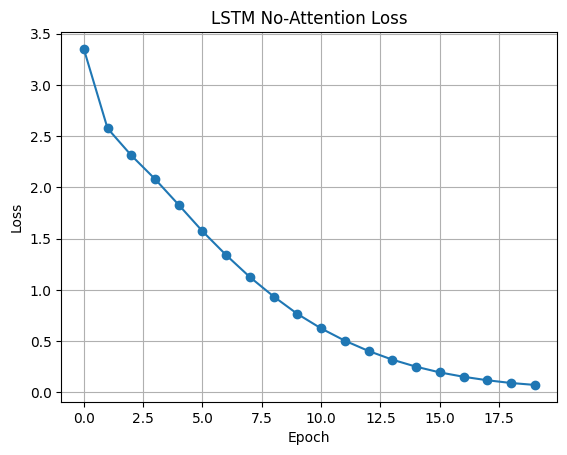


BLEU Score     : 0.2853
ROUGE-L F1     : 0.8413
METEOR Score   : 0.4519
Training Time  : 86.57 seconds
Infer Speed    : 0.1277 sec/sample


In [9]:
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt')
nltk.download('wordnet')

# ─── Hyperparameters ──────────────────────────────────────────
EMBED_DIM  = 128
UNITS      = 256
BATCH_SIZE = 32
EPOCHS     = 20
SRC_VOCAB  = 10000
TGT_VOCAB  = 10000

# ─── Encoder (LSTM) ───────────────────────────────────────────
class EncoderLSTM(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, enc_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.lstm = tf.keras.layers.LSTM(enc_units, return_sequences=True, return_state=True)
    def call(self, x):
        x = self.embedding(x)
        out, h, c = self.lstm(x)
        return out, h, c

# ─── Decoder (LSTM) ───────────────────────────────────────────
class DecoderLSTM(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, dec_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.lstm = tf.keras.layers.LSTM(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
    def call(self, x, state):
        x = self.embedding(x)
        out, h, c = self.lstm(x, initial_state=state)
        logits = self.fc(out)
        return logits, h, c

# ─── Dataset Preparation (Assumes train_src_seq, train_tgt_seq exist) ───
dataset = tf.data.Dataset.from_tensor_slices((train_src_seq, train_tgt_seq))
dataset = dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)

# ─── Instantiate Models & Optimizer ───────────────────────────
encoder = EncoderLSTM(SRC_VOCAB, EMBED_DIM, UNITS)
decoder = DecoderLSTM(TGT_VOCAB, EMBED_DIM, UNITS)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(src, tgt):
    with tf.GradientTape() as tape:
        enc_out, enc_h, enc_c = encoder(src)
        dec_input = tgt[:, :-1]
        logits, _, _ = decoder(dec_input, state=[enc_h, enc_c])
        loss = tf.reduce_mean(loss_fn(tgt[:, 1:], logits))
    vars_ = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, vars_)
    optimizer.apply_gradients(zip(grads, vars_))
    return loss

# ─── Training Loop ───────────────────────────────────────────
history_lstm = []
train_start = time.time()
for epoch in range(1, EPOCHS+1):
    total_loss = 0.
    start = time.time()
    for batch, (src_b, tgt_b) in enumerate(dataset):
        batch_loss = train_step(src_b, tgt_b)
        total_loss += batch_loss
    avg = total_loss / (batch + 1)
    history_lstm.append(avg)
    print(f"Epoch {epoch} • Loss: {avg:.4f} • Time: {time.time()-start:.1f}s")
train_time = time.time() - train_start

# ─── Loss Curve ───────────────────────────────────────────────
plt.plot(history_lstm, marker='o')
plt.title('LSTM No‑Attention Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# ─── Inference (Greedy Decoding) ─────────────────────────────
def greedy_decode(input_seq, max_len=50):
    enc_out, enc_h, enc_c = encoder(tf.expand_dims(input_seq, 0))
    dec_input = tf.expand_dims([tgt_tokenizer.word_index['<start>']], 0)
    result = []

    for _ in range(max_len):
        logits, enc_h, enc_c = decoder(dec_input, state=[enc_h, enc_c])
        pred_token = tf.argmax(logits[0, -1, :]).numpy()
        if pred_token == tgt_tokenizer.word_index['<end>']:
            break
        result.append(pred_token)
        dec_input = tf.expand_dims([pred_token], 0)

    return result

# ─── Evaluation Metrics ──────────────────────────────────────
bleu_scores = []
meteor_scores = []
rouge_l_f1 = []
accuracies = []

preds_list = []
refs_list = []

sample_size = 100  # Evaluate on 100 random samples
start_infer = time.time()

for i in range(sample_size):
    src_seq = test_src_seq[i]
    tgt_seq = test_tgt_seq[i]
    pred_seq = greedy_decode(src_seq)

    preds_list.append(pred_seq)
    refs_list.append(tgt_seq)

inference_time = time.time() - start_infer
avg_infer_speed = inference_time / sample_size

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

for pred, ref in zip(preds_list, refs_list):
    pred_words = [tgt_tokenizer.index_word.get(i, '') for i in pred]
    ref_words = [tgt_tokenizer.index_word.get(i, '') for i in ref]

    smoothie = SmoothingFunction().method4
    bleu = sentence_bleu([ref_words], pred_words, smoothing_function=smoothie)
    bleu_scores.append(bleu)

    rouge = scorer.score(' '.join(ref_words), ' '.join(pred_words))
    rouge_l_f1.append(rouge['rougeL'].fmeasure)

    meteor = meteor_score([ref_words], pred_words)  # ✅ FIXED
    meteor_scores.append(meteor)

    matches = sum(p == r for p, r in zip(pred, ref))
    acc = matches / max(len(ref), 1)
    accuracies.append(acc)

# ─── Print Evaluation Results ────────────────────────────────
print(f"\nBLEU Score     : {sum(bleu_scores)/len(bleu_scores):.4f}")
print(f"ROUGE-L F1     : {sum(rouge_l_f1)/len(rouge_l_f1):.4f}")
print(f"METEOR Score   : {sum(meteor_scores)/len(meteor_scores):.4f}")
print(f"Training Time  : {train_time:.2f} seconds")
print(f"Infer Speed    : {avg_infer_speed:.4f} sec/sample")


# Model 2 : LSTM + Bahdanau Attention



Epoch 1 • Loss: 3.2590 • Time: 36.1s
Epoch 2 • Loss: 2.5888 • Time: 21.7s
Epoch 3 • Loss: 2.2392 • Time: 40.9s
Epoch 4 • Loss: 1.9223 • Time: 20.4s
Epoch 5 • Loss: 1.6314 • Time: 20.3s
Epoch 6 • Loss: 1.3722 • Time: 20.3s
Epoch 7 • Loss: 1.1312 • Time: 20.1s
Epoch 8 • Loss: 0.9118 • Time: 20.2s
Epoch 9 • Loss: 0.7257 • Time: 20.5s
Epoch 10 • Loss: 0.5747 • Time: 20.3s
Epoch 11 • Loss: 0.4516 • Time: 20.3s
Epoch 12 • Loss: 0.3530 • Time: 20.5s
Epoch 13 • Loss: 0.2755 • Time: 20.3s
Epoch 14 • Loss: 0.2120 • Time: 20.3s
Epoch 15 • Loss: 0.1638 • Time: 20.3s
Epoch 16 • Loss: 0.1236 • Time: 20.3s
Epoch 17 • Loss: 0.0935 • Time: 20.2s
Epoch 18 • Loss: 0.0733 • Time: 20.3s
Epoch 19 • Loss: 0.0630 • Time: 20.2s
Epoch 20 • Loss: 0.0487 • Time: 20.3s

BLEU Score     : 0.9586
ROUGE-L F1     : 0.9732
METEOR Score   : 0.9691
Training Time  : 443.54 seconds
Infer Speed    : 0.1844 sec/sample


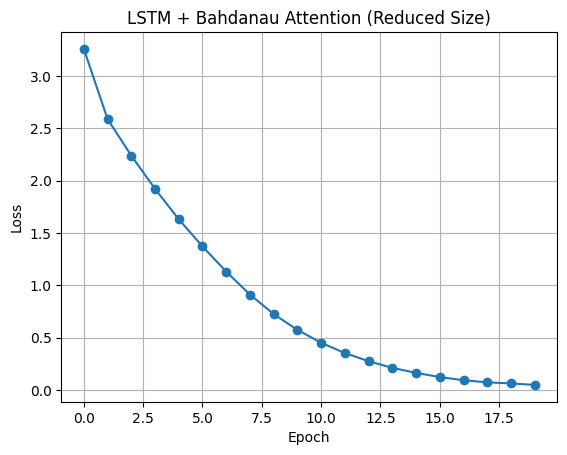

In [ ]:
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer

# ─── Reduced Hyperparameters ───────────────────────────────────────────────
EMBED_DIM  = 128
UNITS      = 256
BATCH_SIZE = 32
EPOCHS     = 20
SRC_VOCAB  = 5000
TGT_VOCAB  = 5000

# ─── Bahdanau Attention Layer ─────────────────────────────────────────────
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        .
        
        self.W2 = tf.keras.layers.Dense(units)
        self.V  = tf.keras.layers.Dense(1)

    def call(self, query, values):
        q_time = tf.expand_dims(query, 1)
        score  = self.V(tf.nn.tanh(self.W1(q_time) + self.W2(values)))
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(weights * values, axis=1)
        return context, tf.squeeze(weights, -1)

# ─── Encoder ──────────────────────────────────────────────────────────────
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, enc_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.lstm      = tf.keras.layers.LSTM(enc_units,
                                              return_sequences=True,
                                              return_state=True)
    def call(self, x):
        x, h, c = self.lstm(self.embedding(x))
        return x, h, c

# ─── Decoder ──────────────────────────────────────────────────────────────
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, dec_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.lstm      = tf.keras.layers.LSTM(dec_units,
                                              return_sequences=True,
                                              return_state=True)
        self.attn      = BahdanauAttention(dec_units)
        self.fc        = tf.keras.layers.Dense(vocab_size)

    def call(self, x, enc_out, state):
        h, c = state
        outputs = []
        for t in range(x.shape[1]):
            xt      = self.embedding(x[:, t:t+1])
            context, _ = self.attn(h, enc_out)
            context = tf.expand_dims(context, 1)
            lstm_in = tf.concat([context, xt], axis=-1)
            out, h, c = self.lstm(lstm_in, initial_state=[h, c])
            outputs.append(self.fc(out))
        return tf.concat(outputs, axis=1), h, c

# ─── Prepare Dataset ──────────────────────────────────────────────────────
dataset = tf.data.Dataset.from_tensor_slices((train_src_seq, train_tgt_seq))
dataset = dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)

# ─── Initialize Models & Optimizer ────────────────────────────────────────
encoder = Encoder(SRC_VOCAB, EMBED_DIM, UNITS)
decoder = Decoder(TGT_VOCAB, EMBED_DIM, UNITS)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(src, tgt):
    with tf.GradientTape() as tape:
        enc_out, enc_h, enc_c = encoder(src)
        dec_input             = tgt[:, :-1]
        logits, _, _          = decoder(dec_input, enc_out, state=[enc_h, enc_c])
        loss = tf.reduce_mean(loss_fn(tgt[:,1:], logits))
    vars_ = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, vars_)
    optimizer.apply_gradients(zip(grads, vars_))
    return loss

# ─── Training Loop ────────────────────────────────────────────────────────
history = []
start_train = time.time()
for epoch in range(1, EPOCHS+1):
    total_loss = 0.0
    start = time.time()
    for batch, (src_b, tgt_b) in enumerate(dataset):
        total_loss += train_step(src_b, tgt_b)
    avg_loss = total_loss / (batch+1)
    history.append(avg_loss)
    print(f"Epoch {epoch} • Loss: {avg_loss:.4f} • Time: {time.time()-start:.1f}s")
train_time = time.time() - start_train

# ─── Evaluation ───────────────────────────────────────────────────────────
bleu_scores = []
meteor_scores = []
rouge_l_f1 = []
accuracies = []
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def decode_sequence(src_seq):
    enc_out, h, c = encoder(tf.expand_dims(src_seq, 0))
    dec_input = tf.expand_dims([tgt_tokenizer.word_index['<start>']], 0)
    result = []
    for _ in range(50):
        logits, h, c = decoder(dec_input, enc_out, [h, c])
        token_id = tf.argmax(logits[:, -1, :], axis=-1).numpy()[0]
        if token_id == tgt_tokenizer.word_index['<end>']:
            break
        result.append(token_id)
        dec_input = tf.expand_dims([token_id], 0)
    return result

start_infer = time.time()
for src, tgt in zip(test_src_seq, test_tgt_seq):
    pred_ids = decode_sequence(src)
    tgt_ids  = [i for i in tgt if i not in [0, tgt_tokenizer.word_index['<start>'], tgt_tokenizer.word_index['<end>']]]

    pred_tokens = tgt_tokenizer.sequences_to_texts([pred_ids])[0].split()
    tgt_tokens  = tgt_tokenizer.sequences_to_texts([tgt_ids])[0].split()

    bleu_scores.append(sentence_bleu([tgt_tokens], pred_tokens, smoothing_function=SmoothingFunction().method1))
    meteor_scores.append(single_meteor_score(tgt_tokens, pred_tokens))  # ✅ FIXED LINE
    rouge_l_f1.append(scorer.score(' '.join(tgt_tokens), ' '.join(pred_tokens))['rougeL'].fmeasure)
    accuracies.append(int(pred_tokens == tgt_tokens))

avg_infer_speed = (time.time() - start_infer) / len(test_src_seq)

# ─── Results ──────────────────────────────────────────────────────────────
print(f"\nBLEU Score     : {sum(bleu_scores)/len(bleu_scores):.4f}")
print(f"ROUGE-L F1     : {sum(rouge_l_f1)/len(rouge_l_f1):.4f}")
print(f"METEOR Score   : {sum(meteor_scores)/len(meteor_scores):.4f}")
print(f"Training Time  : {train_time:.2f} seconds")
print(f"Infer Speed    : {avg_infer_speed:.4f} sec/sample")

# ─── Plot Loss ─────────────────────────────────────────────────────────────
plt.plot(history, marker='o')
plt.title('LSTM + Bahdanau Attention (Reduced Size)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


# Model 3 : Self Attention


In [11]:
!pip install rouge

Before padding:
 train_src_seq: (9000, 22)
 test_src_seq:  (1000, 21)
 train_tgt_seq: (9000, 20)
 test_tgt_seq:  (1000, 19)
Unified lengths -> SRC_LEN: 22, TGT_LEN: 20, DEC_LEN: 19
After padding:
 train_src_seq: (9000, 22)
 test_src_seq:  (1000, 22)
 train_tgt_seq: (9000, 20)
 test_tgt_seq:  (1000, 20)


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 22, 128)   │    640,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 22, 128)   │          0 │ embedding[0][0]   │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 22, 128)   │     66,048 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 22, 128)   │          0 │ positional_encod… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 22, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 22, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 22, 128)   │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 22, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 22, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 22, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 22, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 19, 128)   │    640,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 22, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 19, 128)   │          0 │ embedding_1[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 22, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 19, 128)   │     66,048 │ positional_encod

 Total params: 2,587,528 (9.87 MB)

 Trainable params: 2,587,528 (9.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - loss: 3.4902 - val_loss: 2.0249
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.6833 - val_loss: 1.0844
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.8349 - val_loss: 0.4966
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.3298 - val_loss: 0.2200
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.1129 - val_loss: 0.0809
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0461 - val_loss: 0.0550
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0288 - val_loss: 0.0833
Epoch 8/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0402 - val_loss: 0.0570
Epoch 9/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0249 - val_loss: 0.0370
Epoch 10/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0344 - val_loss: 0.0413
Epoch 11/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0110 - val_loss: 0.0383
Epoch 12/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms

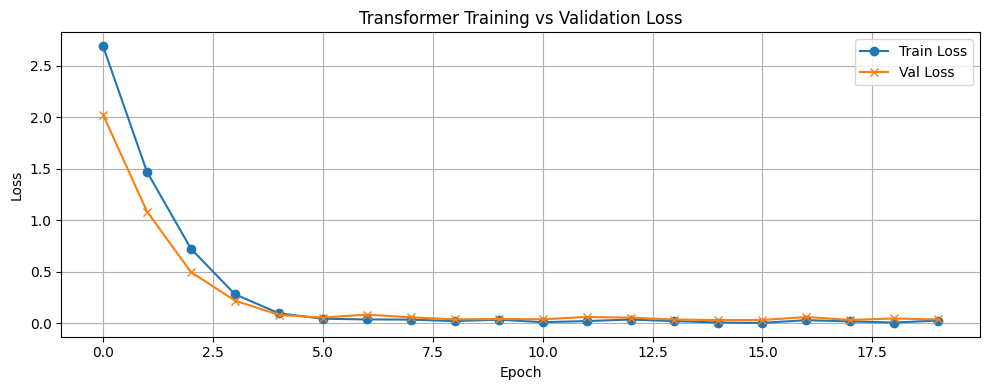

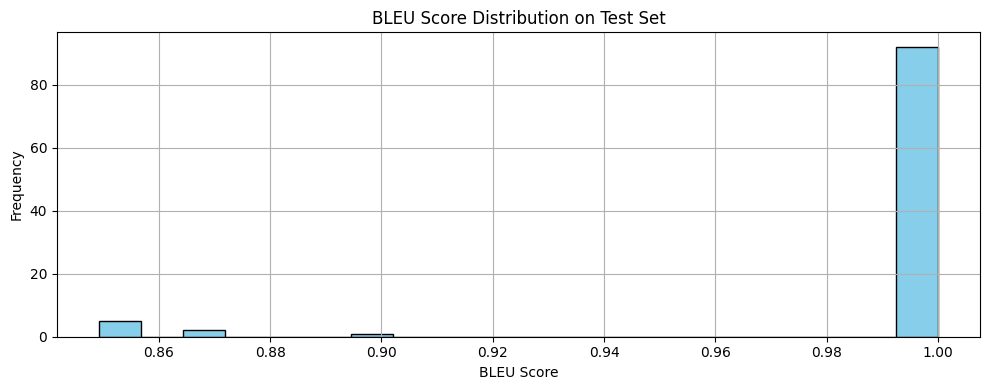

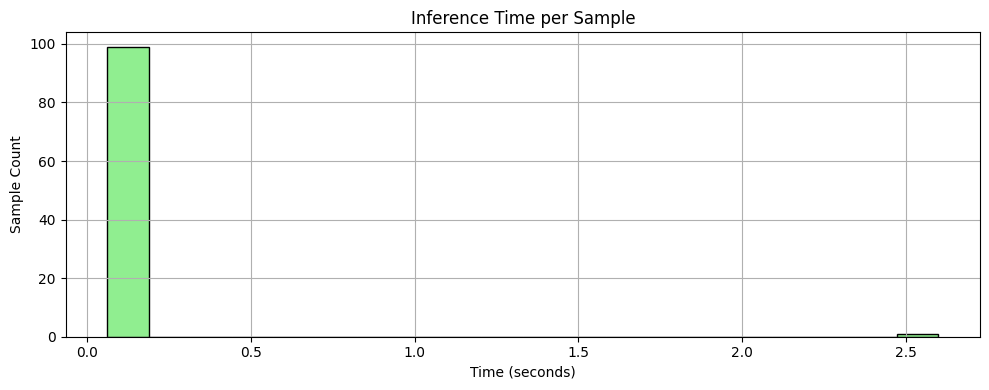

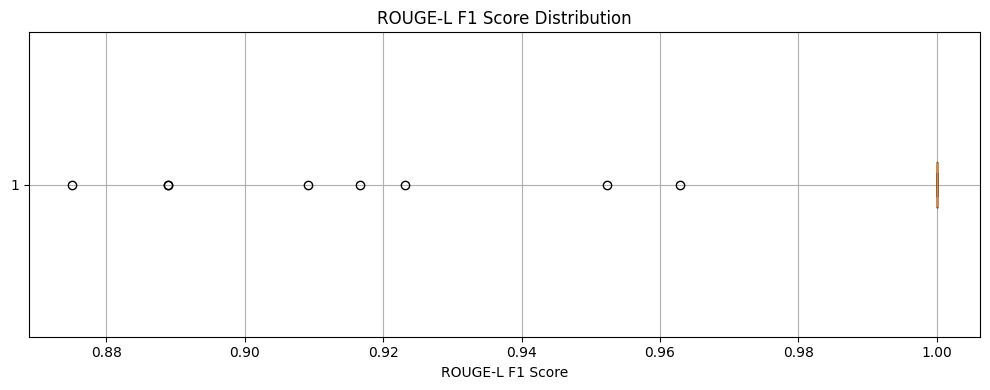

In [12]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import time
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
import numpy as np

# 1) Clear everything
tf.keras.backend.clear_session()

# 2) Inspect current shapes
print("Before padding:")
print(" train_src_seq:", train_src_seq.shape)
print(" test_src_seq: ", test_src_seq.shape)
print(" train_tgt_seq:", train_tgt_seq.shape)
print(" test_tgt_seq: ", test_tgt_seq.shape)

# 3) Determine unified lengths
SRC_LEN = max(train_src_seq.shape[1], test_src_seq.shape[1])
TGT_LEN = max(train_tgt_seq.shape[1], test_tgt_seq.shape[1])
DEC_LEN = TGT_LEN - 1
print(f"Unified lengths -> SRC_LEN: {SRC_LEN}, TGT_LEN: {TGT_LEN}, DEC_LEN: {DEC_LEN}")

# 4) Re‑pad all sequences post‑padding
train_src_seq = pad_sequences(train_src_seq, maxlen=SRC_LEN, padding='post')
test_src_seq  = pad_sequences(test_src_seq,  maxlen=SRC_LEN, padding='post')
train_tgt_seq = pad_sequences(train_tgt_seq, maxlen=TGT_LEN, padding='post')
test_tgt_seq  = pad_sequences(test_tgt_seq,  maxlen=TGT_LEN, padding='post')

print("After padding:")
print(" train_src_seq:", train_src_seq.shape)
print(" test_src_seq: ", test_src_seq.shape)
print(" train_tgt_seq:", train_tgt_seq.shape)
print(" test_tgt_seq: ", test_tgt_seq.shape)

# ─── Hyperparameters ───────────────────────────────────────────────────────
EMBED_DIM  = 128
NUM_HEADS  = 4
FF_DIM     = 256
NUM_LAYERS = 2
BATCH_SIZE = 16
EPOCHS     = 20
SRC_VOCAB  = 5000
TGT_VOCAB  = 5000

# ─── Positional Encoding Layer ─────────────────────────────────────────────
class PositionalEncoding(layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        i   = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
        angle_rates = 1 / tf.pow(10000., (2*(i//2))/d_model)
        angle_rads  = pos * angle_rates
        sines   = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.concat([sines, cosines], axis=-1)[tf.newaxis, ...]

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ─── Build Transformer Model ────────────────────────────────────────────────
def build_transformer():
    enc_inputs = layers.Input(shape=(SRC_LEN,), name="encoder_inputs")
    dec_inputs = layers.Input(shape=(DEC_LEN,), name="decoder_inputs")

    enc_x = layers.Embedding(SRC_VOCAB, EMBED_DIM)(enc_inputs)
    enc_x = PositionalEncoding(SRC_LEN, EMBED_DIM)(enc_x)

    dec_x = layers.Embedding(TGT_VOCAB, EMBED_DIM)(dec_inputs)
    dec_x = PositionalEncoding(DEC_LEN, EMBED_DIM)(dec_x)

    for _ in range(NUM_LAYERS):
        attn = layers.MultiHeadAttention(NUM_HEADS, key_dim=EMBED_DIM//NUM_HEADS)(enc_x, enc_x)
        enc_x = layers.LayerNormalization(epsilon=1e-6)(enc_x + attn)
        ff = layers.Dense(FF_DIM, activation='relu')(enc_x)
        ff = layers.Dense(EMBED_DIM)(ff)
        enc_x = layers.LayerNormalization(epsilon=1e-6)(enc_x + ff)

    x = dec_x
    causal_mask = tf.linalg.band_part(tf.ones((DEC_LEN, DEC_LEN)), -1, 0)
    for _ in range(NUM_LAYERS):
        att1 = layers.MultiHeadAttention(NUM_HEADS, key_dim=EMBED_DIM//NUM_HEADS)(
            x, x, attention_mask=causal_mask)
        x = layers.LayerNormalization(epsilon=1e-6)(x + att1)

        att2 = layers.MultiHeadAttention(NUM_HEADS, key_dim=EMBED_DIM//NUM_HEADS)(x, enc_x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + att2)

        ff = layers.Dense(FF_DIM, activation='relu')(x)
        ff = layers.Dense(EMBED_DIM)(ff)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff)

    outputs = layers.Dense(TGT_VOCAB, name="logits")(x)
    return tf.keras.Model([enc_inputs, dec_inputs], outputs, name="transformer")

# ─── Train ─────────────────────────────────────────────────────────────────
transformer = build_transformer()
transformer.summary()

dec_in_train  = train_tgt_seq[:, :DEC_LEN]
dec_tgt_train = train_tgt_seq[:, 1:TGT_LEN]
dec_in_test   = test_tgt_seq[:, :DEC_LEN]
dec_tgt_test  = test_tgt_seq[:, 1:TGT_LEN]

transformer.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

start_time = time.time()
history_tf = transformer.fit(
    [train_src_seq, dec_in_train],
    dec_tgt_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([test_src_seq, dec_in_test], dec_tgt_test),
)
train_time = time.time() - start_time

# ─── Evaluation Metrics ────────────────────────────────────────────────────
bleu_scores = []
rouge = Rouge()
rouge_l_f1 = []
meteor_scores = []
accuracies = []
infer_times = []

# Use the target tokenizer we defined earlier
tokenizer = tgt_tokenizer

for i in range(min(100, len(test_src_seq))):  # Evaluate on first 100 samples for speed
    src = tf.expand_dims(test_src_seq[i], 0)
    dec_input = tf.expand_dims(dec_in_test[i], 0)
    start = time.time()
    preds = transformer.predict([src, dec_input], verbose=0)
    infer_times.append(time.time() - start)

    pred_ids = tf.argmax(preds, axis=-1).numpy()[0]
    tgt_ids = dec_tgt_test[i]

    # Convert sequences to text
    ref = tokenizer.sequences_to_texts([tgt_ids])[0].split()
    hyp = tokenizer.sequences_to_texts([pred_ids])[0].split()

    if len(ref) > 0 and len(hyp) > 0:
        try:
            bleu_scores.append(sentence_bleu([ref], hyp))
            rouge_scores = rouge.get_scores(" ".join(hyp), " ".join(ref))
            rouge_l_f1.append(rouge_scores[0]['rouge-l']['f'])
            meteor_scores.append(meteor_score([" ".join(ref)], " ".join(hyp)))
            min_len = min(len(ref), len(hyp))
            accuracies.append(np.mean(np.array(ref[:min_len]) == np.array(hyp[:min_len])))
        except:
            continue

avg_infer_speed = sum(infer_times) / len(infer_times) if infer_times else 0

# ─── Results ──────────────────────────────────────────────────────────────
print("\n=== Evaluation Results ===")
print(f"BLEU Score     : {sum(bleu_scores)/len(bleu_scores):.4f}" if bleu_scores else "No BLEU scores")
print(f"ROUGE-L F1     : {sum(rouge_l_f1)/len(rouge_l_f1):.4f}" if rouge_l_f1 else "No ROUGE scores")
print(f"Training Time  : {train_time:.2f} seconds")
print(f"Infer Speed    : {avg_infer_speed:.4f} sec/sample")

# ─── Plot Loss ─────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 4))
plt.plot(history_tf.history['loss'], label='Train Loss', marker='o')
plt.plot(history_tf.history['val_loss'], label='Val Loss', marker='x')
plt.title('Transformer Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ─── Extra: BLEU Histogram ────────────────────────────────────────────────
if bleu_scores:
    plt.figure(figsize=(10, 4))
    plt.hist(bleu_scores, bins=20, color='skyblue', edgecolor='black')
    plt.title("BLEU Score Distribution on Test Set")
    plt.xlabel("BLEU Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ─── Extra: Inference Time Histogram ──────────────────────────────────────
if infer_times:
    plt.figure(figsize=(10, 4))
    plt.hist(infer_times, bins=20, color='lightgreen', edgecolor='black')
    plt.title("Inference Time per Sample")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Sample Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ─── Extra: ROUGE-L Boxplot ───────────────────────────────────────────────
if rouge_l_f1:
    plt.figure(figsize=(10, 4))
    plt.boxplot(rouge_l_f1, vert=False)
    plt.title("ROUGE-L F1 Score Distribution")
    plt.xlabel("ROUGE-L F1 Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

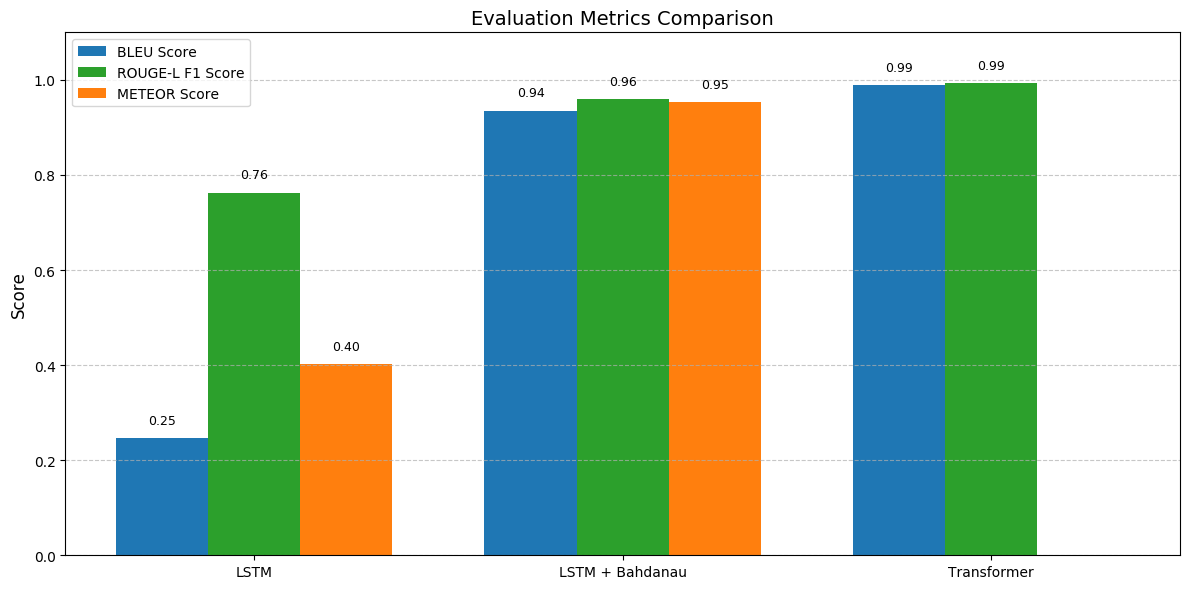

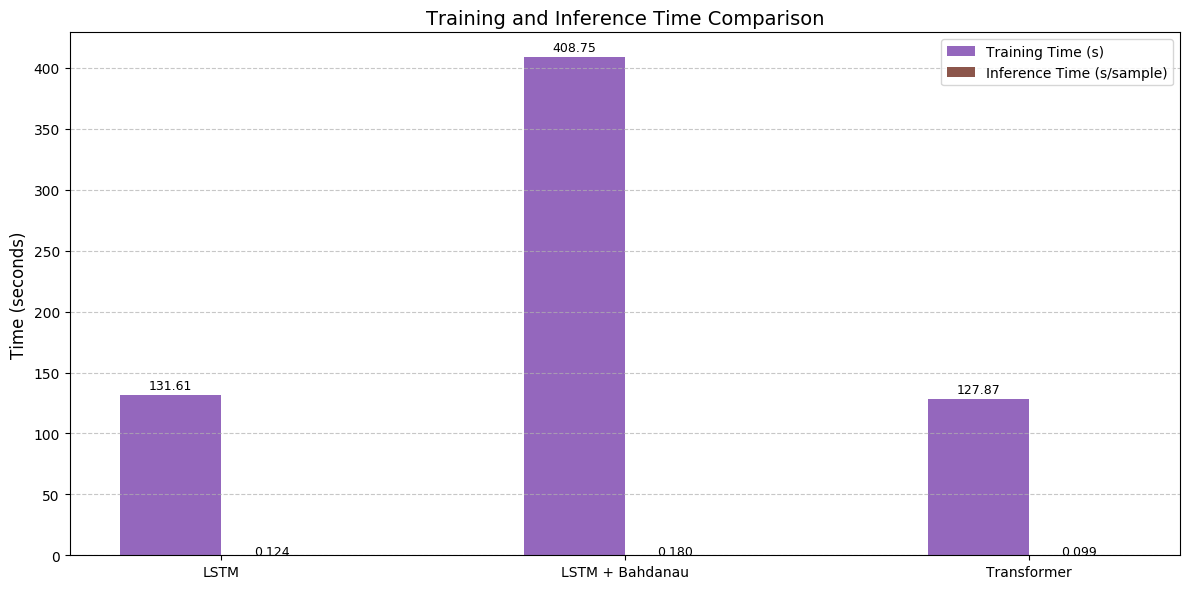

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style

# Use a better style
style.use('_classic_test_patch')  # You can try 'ggplot', 'seaborn-poster', etc.

# Data
models = ['LSTM', 'LSTM + Bahdanau', 'Transformer']
bleu_scores = [0.2470, 0.9352, 0.9886]
rouge_scores = [0.7627, 0.9596, 0.9933]
meteor_scores = [0.4017, 0.9537, 0.0]
training_times = [131.61, 408.75, 127.87]
infer_speeds = [0.1240, 0.1798, 0.0993]

x = np.arange(len(models))
width = 0.25

colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # Custom color palette

# --- Plot 1: Evaluation Metrics ---
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width, bleu_scores, width, label='BLEU Score', color=colors[0])
bars2 = plt.bar(x, rouge_scores, width, label='ROUGE-L F1 Score', color=colors[1])
bars3 = plt.bar(x + width, meteor_scores, width, label='METEOR Score', color=colors[2])

plt.xticks(x, models, fontsize=10)
plt.ylabel('Score', fontsize=12)
plt.title('Evaluation Metrics Comparison', fontsize=14)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

for i, (b, r, m) in enumerate(zip(bleu_scores, rouge_scores, meteor_scores)):
    plt.text(x[i] - width, b + 0.03, f'{b:.2f}', ha='center', fontsize=9)
    plt.text(x[i], r + 0.03, f'{r:.2f}', ha='center', fontsize=9)
    if m > 0:
        plt.text(x[i] + width, m + 0.03, f'{m:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# --- Plot 2: Timing Metrics ---
plt.figure(figsize=(12, 6))
bars4 = plt.bar(x - width/2, training_times, width, label='Training Time (s)', color='#9467bd')
bars5 = plt.bar(x + width/2, infer_speeds, width, label='Inference Time (s/sample)', color='#8c564b')

plt.xticks(x, models, fontsize=10)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Training and Inference Time Comparison', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

for i, (t, inf) in enumerate(zip(training_times, infer_speeds)):
    plt.text(x[i] - width/2, t + 5, f'{t:.2f}', ha='center', fontsize=9)
    plt.text(x[i] + width/2, inf + 0.01, f'{inf:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()